<h1 style="text-align: center; font-weight: bold;">Initiation à l'Inverse Reinforcement Learning</h1>
<h3 style="text-align: center; color: gray;">Premier cas d'application : robot à deux axes</h3>

In [2]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
opti = Opti()

# cadre du problème
# temporel
t_0 = 0
t_f = 1
N = 10  # nombre de points de discrétisation
dt = (t_f - t_0) / N

# longueurs
L_1 = 1
L_2 = 1
N_angles = 2

# variables à optimiser
q = opti.variable(N_angles, N)
dq = opti.variable(N_angles, N)

# déclaration de la matrice de poids
# NOTE : j'avais mis des np.ones au début, mais cela ne marchait pas, il faut essayer de rester avec des objets casadi
w_1 = DM.ones((2, 10))
w_2 = DM.ones(10)

# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = dq**2
J_1 = w_1[0,:] @ Phi_1[0,:].T + w_1[1,:] @ Phi_1[1,:].T

# \Phi_2 : coût sur la vitesse linéaire en abscisse
# Phi_2 = (L_1*sin(q))
J_2 = 0
for t in range(N):
    # q1_t = q[0, t]
    # q2_t = q[1, t]
    # J_2 +=  w_2[t] * (L_1*sin(q1_t) + L_2*(cos(q2_t)*sin(q1_t) + sin(q2_t)*cos(q1_t)))**2 + (L_2*(cos(q1_t)*sin(q2_t) + sin(q1_t)*cos(q2_t)))**2
    J_2 +=  w_2[t] * (L_1*sin(q[0, t]) + L_2*(cos(q[1, t])*sin(q[0, t]) + sin(q[1, t])*cos(q[0, t])))**2 + (L_2*(cos(q[0, t])*sin(q[1, t]) + sin(q[0, t])*cos(q[1, t])))**2
# J_2 = w[1, :] * Phi_2**2

# fonction que l'on cherche à minimiser
opti.minimize(J_1 + J_2)

# contraintes d’intégration
for t in range(N-1):
    opti.subject_to(q[:, t+1] == q[:, t] + dt * dq[:, t])
opti.subject_to(q[:, 0] == [0, pi])
opti.subject_to(L_1*cos(q[0, -1]) + L_2*cos(q[0, -1] + q[1, -1]) == 1)

# conditions supplémentaires sur les angles, non demandé dans l'énoncé
# opti.subject_to(opti.bounded(-pi/2, q, pi/2))

opti.solver("ipopt")
sol = opti.solve()

q1 = sol.value(q[0,:])
q2 = sol.value(q[1,:])

dq1 = sol.value(dq[0,:])
dq2 = sol.value(dq[1,:])

print("q1 =", q1)
print("q2 =", q2)
print("dq1 =", dq1)
print("dq2 =", dq2)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       58
Number of nonzeros in inequality constraint Jacobian.:       20
Number of nonzeros in Lagrangian Hessian.............:       50

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       21
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       20
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.18e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

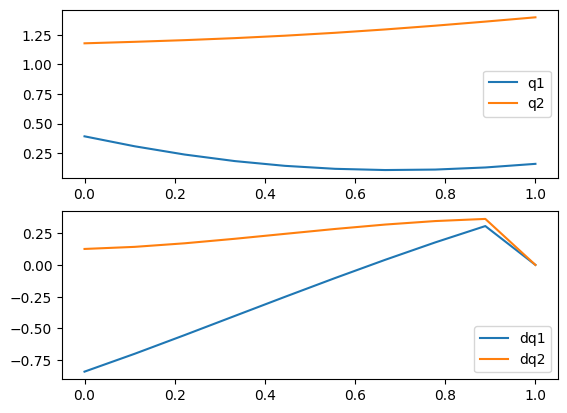

In [62]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.linspace(t_0, t_f, N), q1, label='q1')
plt.plot(np.linspace(t_0, t_f, N), q2, label='q2')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.linspace(t_0, t_f, N), dq1, label='dq1')
plt.plot(np.linspace(t_0, t_f, N), dq2, label='dq2')
plt.legend()
plt.show()

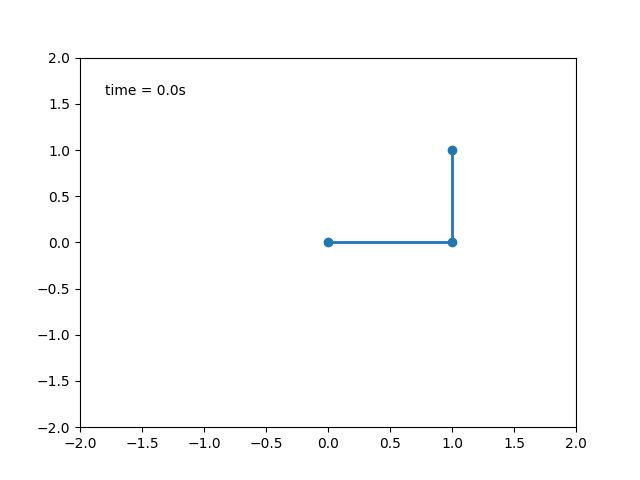

In [64]:
# Animation du robot

# Import des librairies pour générer le gif, et création du gif

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
L1 = 1
L2 = 1
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text
def animate(i):
    thisx = [0, L1*cos(q1[i]), L1*cos(q1[i]) + L2*cos(q1[i] + q2[i])]
    thisy = [0, L1*sin(q1[i]), L1*sin(q1[i]) + L2*sin(q1[i] + q2[i])]
    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text
ani = animation.FuncAnimation(fig, animate, frames=N, interval=100, blit=True, init_func=init)
writergif = PillowWriter(fps=10)
# ani.save('robot_arm.gif', writer=writergif)

# affichage du gif
from IPython.display import Image
Image(open('robot_arm_v1.gif','rb').read())